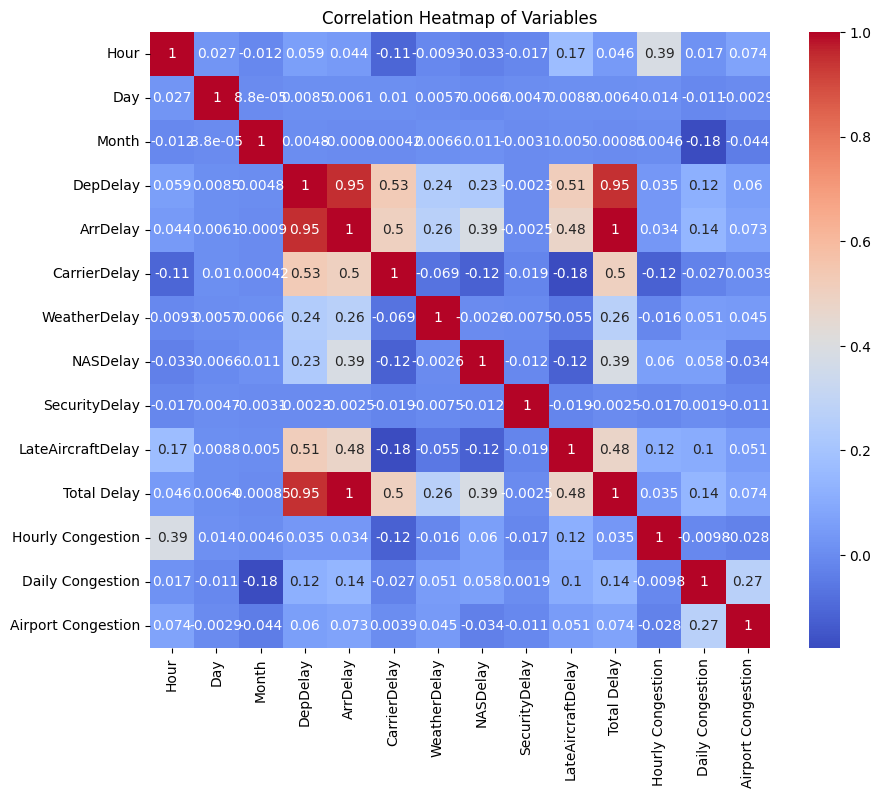

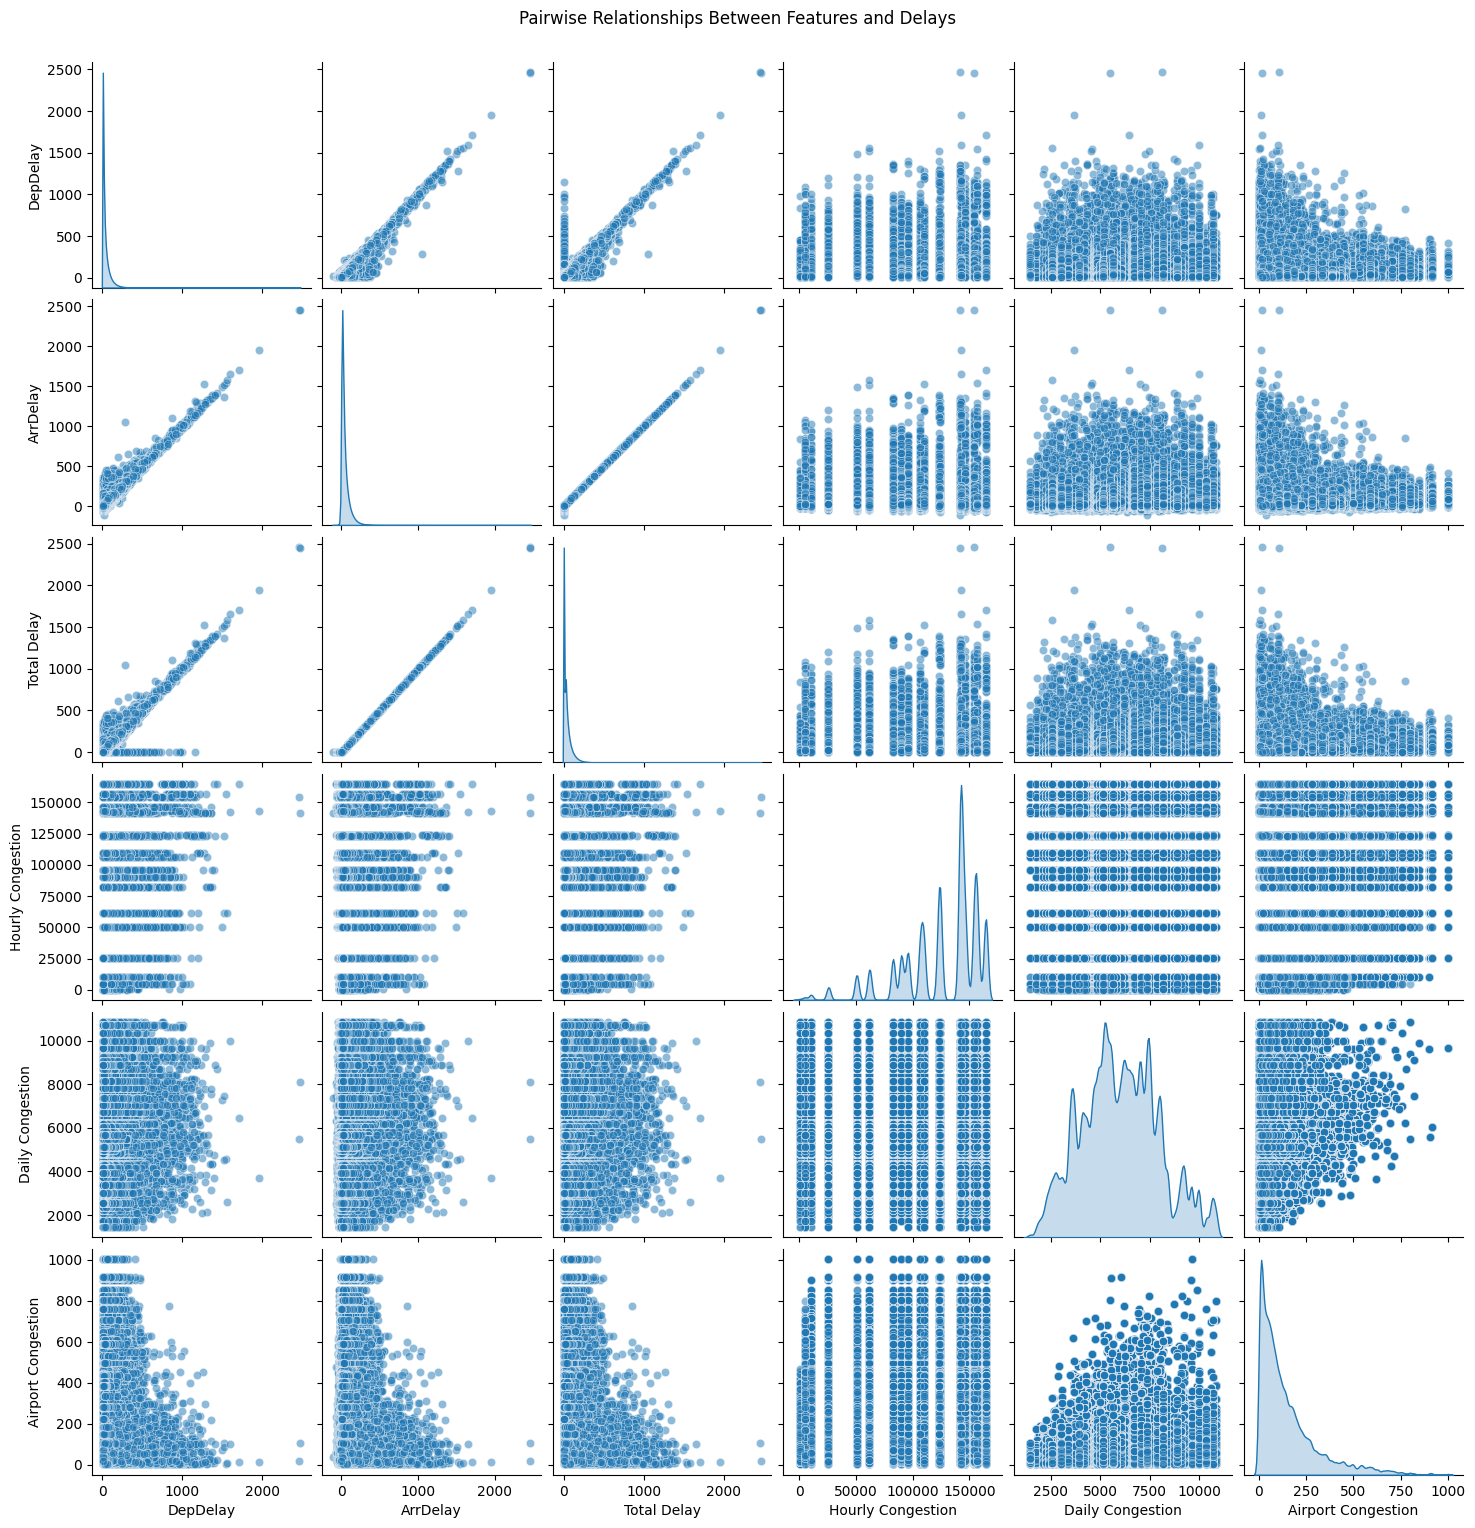

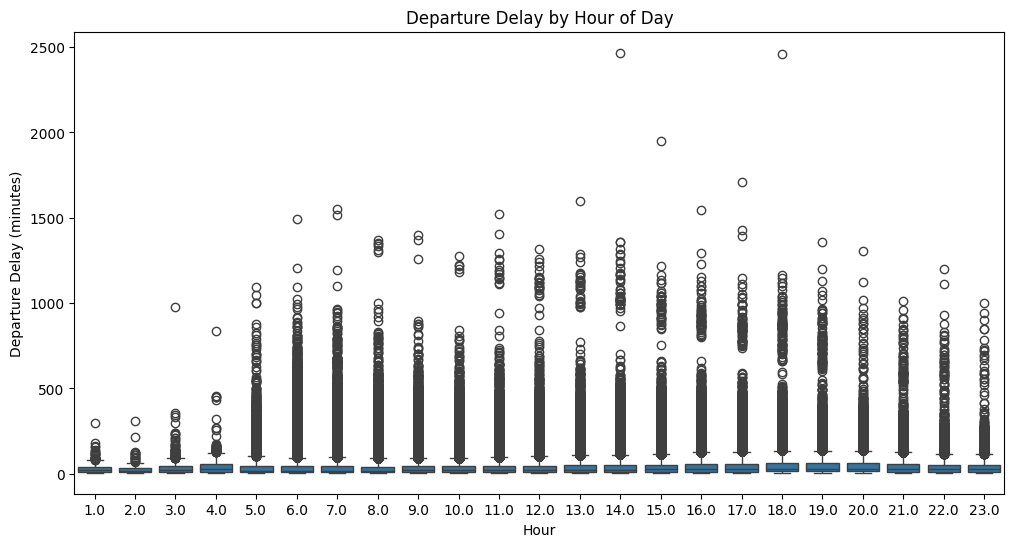

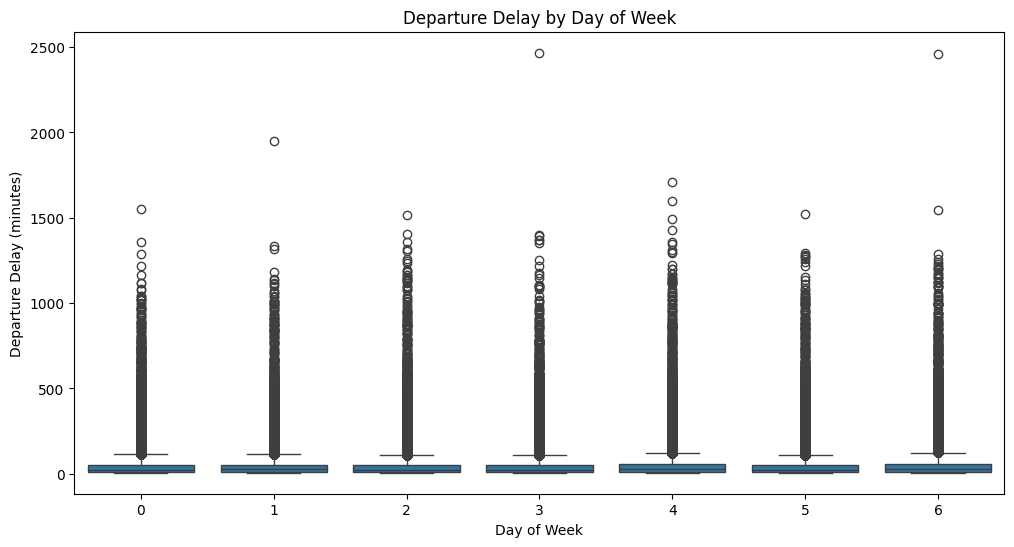

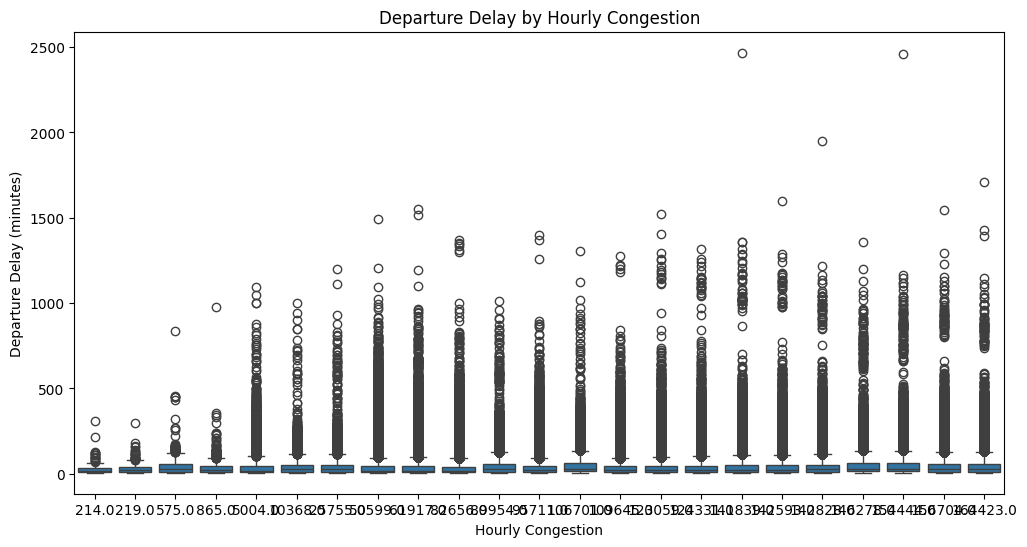

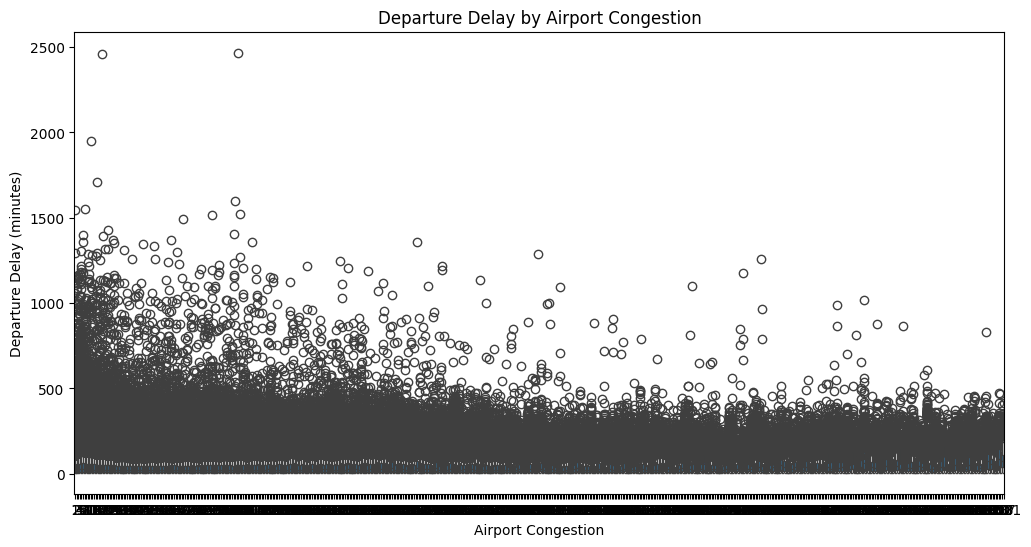

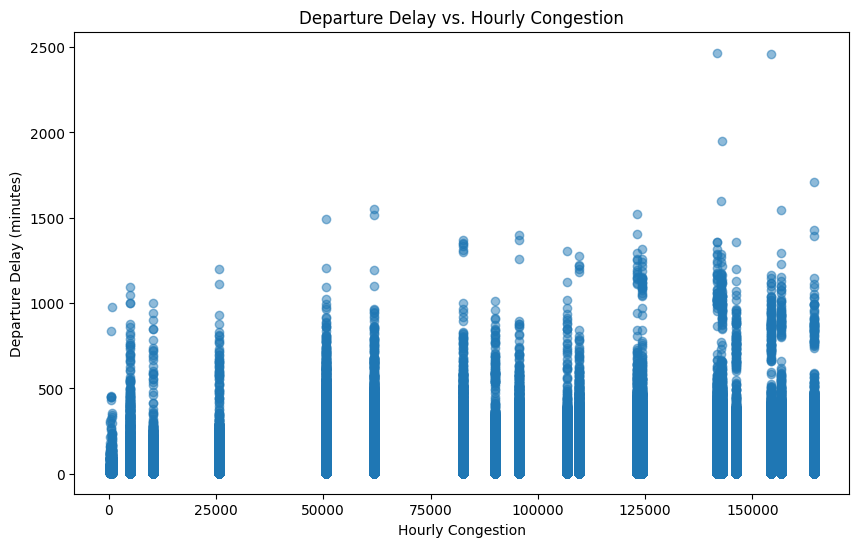

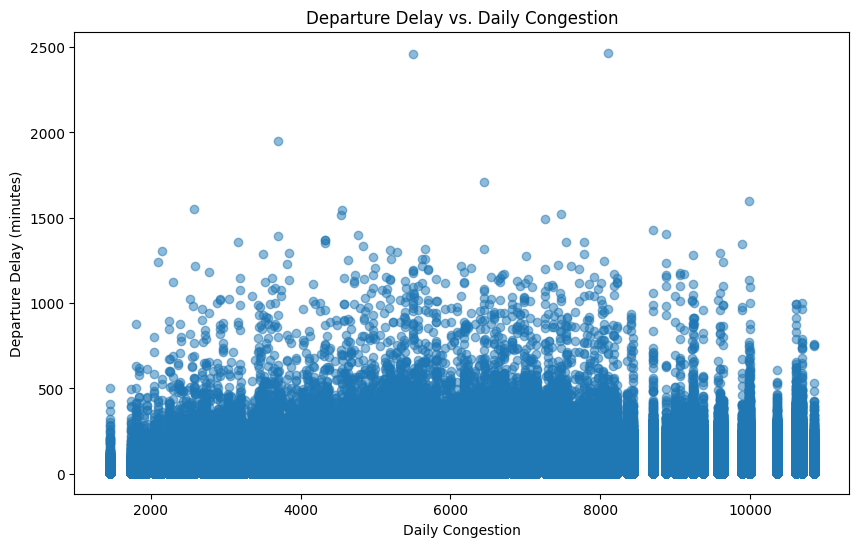

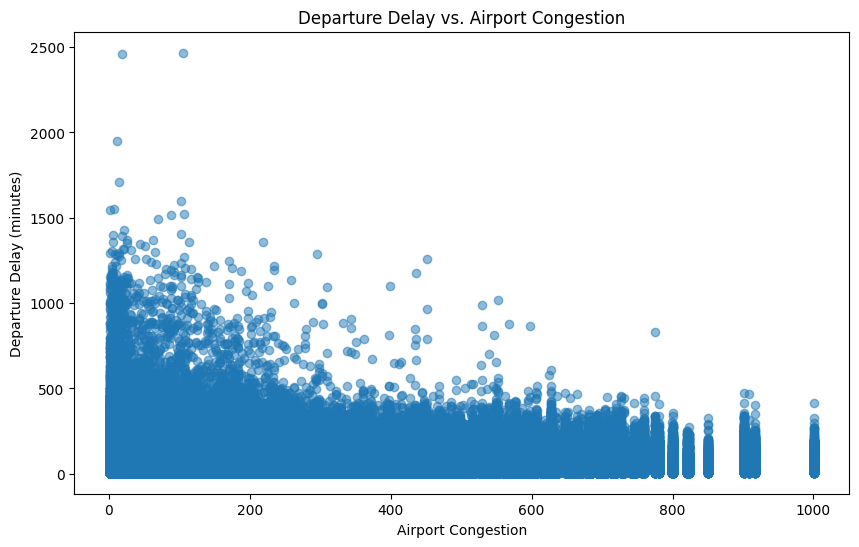

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the dataset from Kaggle
flights_data = pd.read_csv('DelayedFlights.csv')

# Ensure datetime columns are parsed correctly
flights_data['FL_DATE'] = pd.to_datetime(flights_data[['Year', 'Month', 'DayofMonth']].rename(columns={'Year': 'year', 'Month': 'month', 'DayofMonth': 'day'}))

# Add new columns for hour, day of the week, and month
flights_data['Hour'] = pd.to_datetime(flights_data['CRSDepTime'], format='%H%M', errors='coerce').dt.hour
flights_data['Day'] = flights_data['FL_DATE'].dt.dayofweek
flights_data['Month'] = flights_data['FL_DATE'].dt.month

# Total delay and delay categories
flights_data['Total Delay'] = flights_data[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].sum(axis=1, skipna=True)
flights_data['Delay Category'] = pd.cut(
    flights_data['Total Delay'],
    bins=[-1, 0, 15, 60, float('inf')],
    labels=['On Time', 'Short Delay', 'Moderate Delay', 'Long Delay']
)

# Congestion Metrics
# 1. Hourly congestion: Number of flights in the same hour
flights_data['Hourly Congestion'] = flights_data.groupby('Hour')['Hour'].transform('count')

# 2. Daily congestion: Number of flights on the same day
flights_data['Daily Congestion'] = flights_data.groupby('FL_DATE')['FL_DATE'].transform('count')

# 3. Airport congestion: Number of flights departing from the same airport on the same day
flights_data['Airport Congestion'] = flights_data.groupby(['FL_DATE', 'Origin'])['Origin'].transform('count')

# Visualize Correlations Between Variables
columns_to_check = [
    'Hour', 'Day', 'Month', 'DepDelay', 'ArrDelay', 'CarrierDelay', 'WeatherDelay',
    'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Total Delay',
    'Hourly Congestion', 'Daily Congestion', 'Airport Congestion'
]

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(flights_data[columns_to_check].corr(), annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap of Variables')
plt.show()

# Pairplot for selected variables
sns.pairplot(
    flights_data,
    vars=['DepDelay', 'ArrDelay', 'Total Delay', 'Hourly Congestion', 'Daily Congestion', 'Airport Congestion'],
    diag_kind='kde',
    plot_kws={"alpha": 0.5}
)
plt.suptitle('Pairwise Relationships Between Features and Delays', y=1.02)
plt.show()

# Boxplots to explore congestion relationships
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='DepDelay', data=flights_data)
plt.title('Departure Delay by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Day', y='DepDelay', data=flights_data)
plt.title('Departure Delay by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Hourly Congestion', y='DepDelay', data=flights_data)
plt.title('Departure Delay by Hourly Congestion')
plt.xlabel('Hourly Congestion')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Airport Congestion', y='DepDelay', data=flights_data)
plt.title('Departure Delay by Airport Congestion')
plt.xlabel('Airport Congestion')
plt.ylabel('Departure Delay (minutes)')
plt.show()

# Scatter plots for congestion relationships
plt.figure(figsize=(10, 6))
plt.scatter(
    flights_data['Hourly Congestion'], 
    flights_data['DepDelay'], 
    alpha=0.5
)
plt.title('Departure Delay vs. Hourly Congestion')
plt.xlabel('Hourly Congestion')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    flights_data['Daily Congestion'], 
    flights_data['DepDelay'], 
    alpha=0.5
)
plt.title('Departure Delay vs. Daily Congestion')
plt.xlabel('Daily Congestion')
plt.ylabel('Departure Delay (minutes)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(
    flights_data['Airport Congestion'], 
    flights_data['DepDelay'], 
    alpha=0.5
)
plt.title('Departure Delay vs. Airport Congestion')
plt.xlabel('Airport Congestion')
plt.ylabel('Departure Delay (minutes)')
plt.show()


Mean Absolute Error: 6.50
Root Mean Squared Error: 14.92
R^2 Score: 0.92


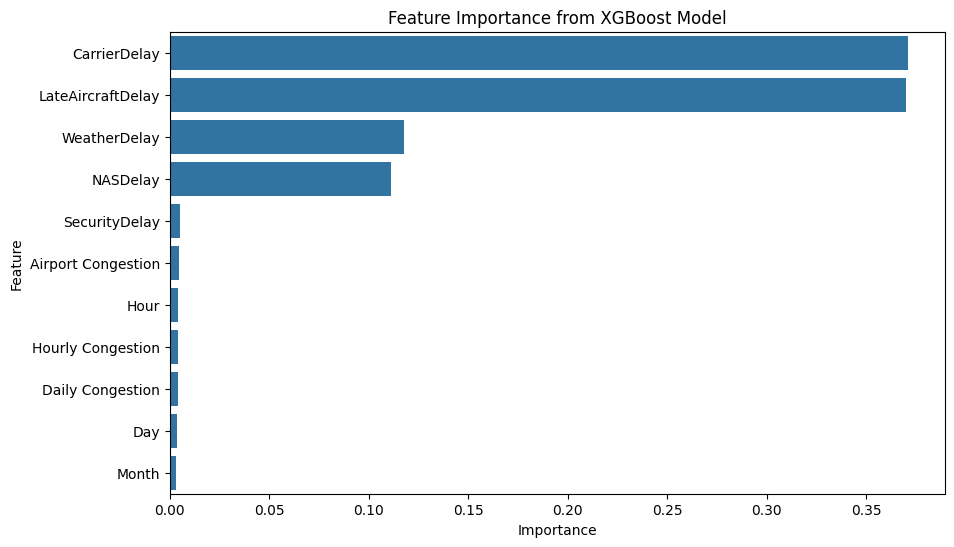

In [30]:
# Drop rows with missing target variable 'DepDelay'
flights_data = flights_data.dropna(subset=['DepDelay'])

# Features and target selection
features = ['Hour', 'Day', 'Month', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
            'Hourly Congestion', 'Daily Congestion', 'Airport Congestion']
target = 'DepDelay'

X = flights_data[features]
y = flights_data[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Feature Importance
plt.figure(figsize=(10, 6))
importance = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from XGBoost Model')
plt.show()